In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee as mc

## Sample 5D Gaussian

In [7]:
def log_prob(x, mu, cov):
    """returns log probability of Gaussian pdf"""
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))


In [8]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

# calculate the covariance matrix. Equations?
cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [9]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [10]:
sampler = mc.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

# burn-in 100 steps
state = sampler.run_mcmc(p0, 100)
sampler.reset()

#production run
sampler.run_mcmc(state, 10000)
#retrieve sample
samples = sampler.get_chain(flat=True)


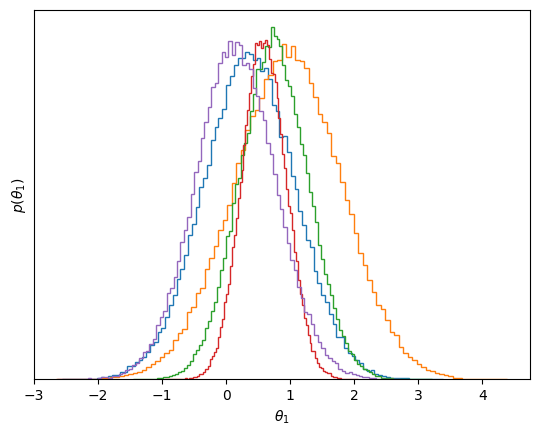

In [11]:
[plt.hist(samples[:, i], 100, histtype="step") for i in range(5)]
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

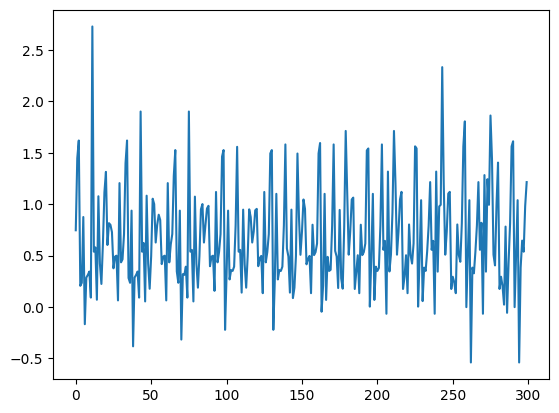

In [12]:
plt.plot(np.arange(300),samples[:300,2]);

In [13]:
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time:  {np.mean(sampler.get_autocorr_time()):.3f}")

Mean acceptance fraction: 0.552
Mean autocorrelation time:  57.112


## Fitting model to data

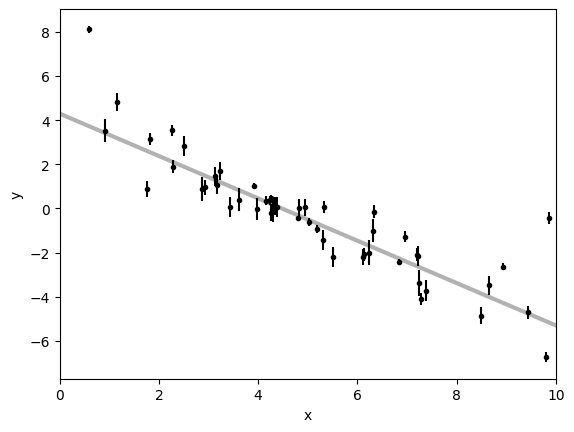

In [14]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


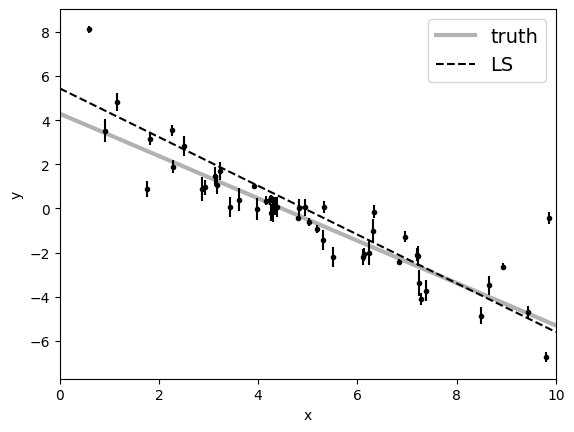

In [15]:
# LEAST SQUARE FIT
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## maximum likelihood

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


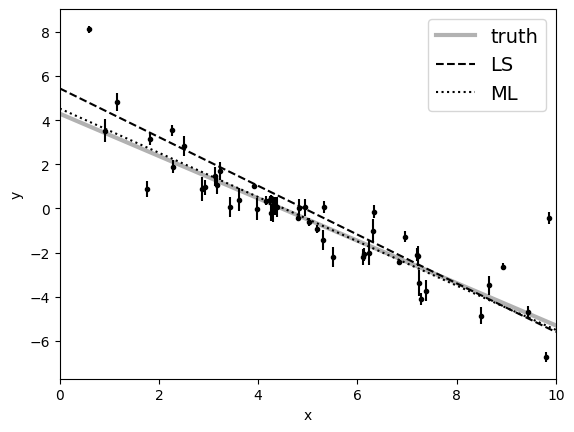

In [18]:
def log_likelihood(theta, x, y, yerr):
    """log likelihood of gaussian"""
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [26]:
soln.x[1:]

array([ 4.52831428, -0.79044033])

## Marginalization & uncertainty estimation

In [28]:
def log_prior(theta):
    b, log_f = theta
    if 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    """log likelihood of gaussian"""
    b, log_f = theta
    m = -1
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [46]:
# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
pos = soln.x[1:] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = 32,2


sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1476.32it/s]


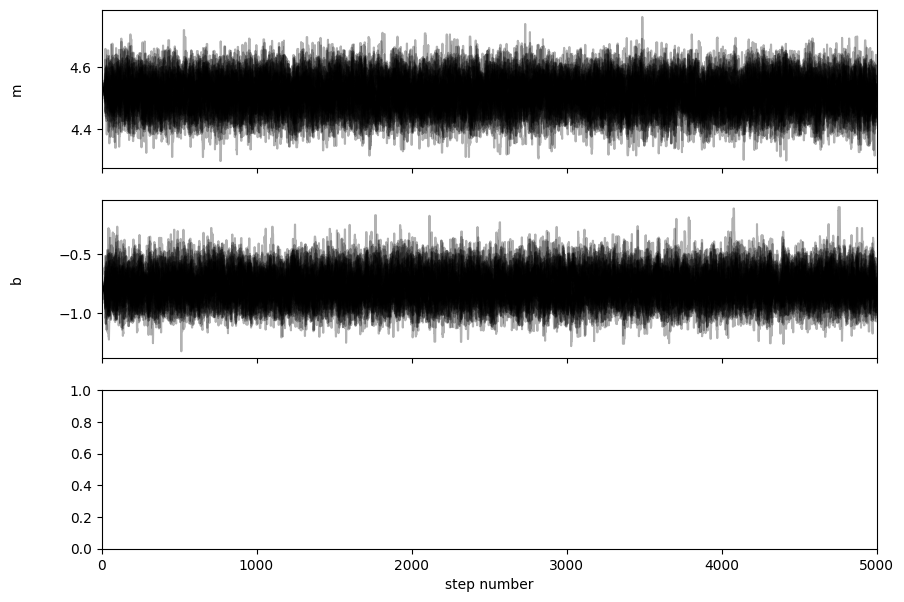

In [30]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [32]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


In [42]:
b_true

4.294

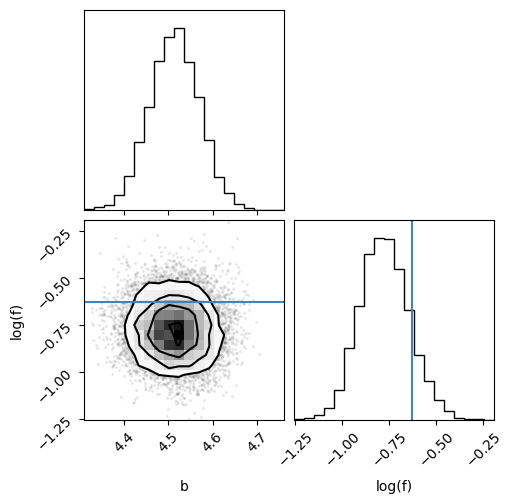

In [43]:
import corner
labels = [ "b", "log(f)"]
fig = corner.corner(
    flat_samples, labels=labels, truths=[b_true, np.log(f_true)]
);

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [44]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [54]:
-2*log_likelihood(np.array([np.percentile(flat_samples[:, i], 50) for i in range(ndim)]), x, y, yerr)+2*np.log(50)

32.19425480924146